# Create map of parcel data and buildings

In [1]:
# set up
import os
import geopandas
import matplotlib.pyplot as plt
import numpy as np

os.chdir("../data/")

In [2]:
# load data
parcels = geopandas.read_file('Parcels_FY19')
buildings = geopandas.read_file('Buildings')

# Exploratory maps 

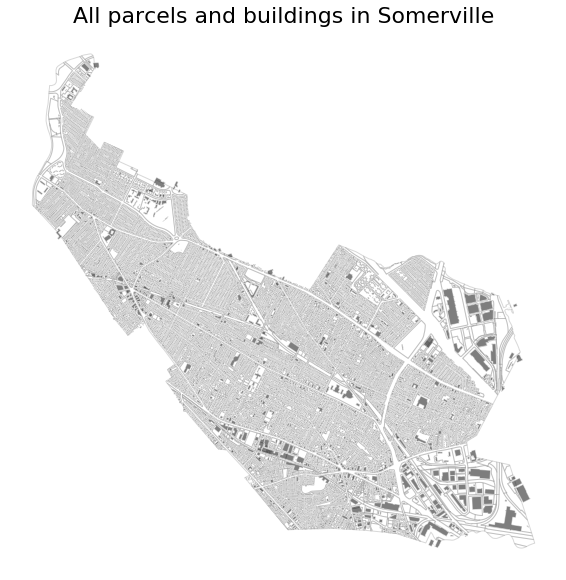

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
parcels.plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
buildings.plot(ax=ax, color='black', edgecolor='white', alpha=0.5)
plt.title("All parcels and buildings in Somerville", fontsize=22)
plt.axis('off');

It's hard to make sense of this, so let's zoom in on a street.

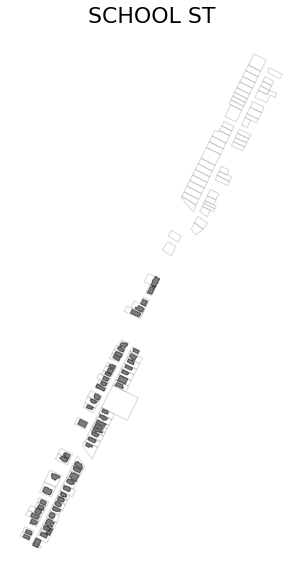

In [6]:
STREET = 'SCHOOL ST'

fig, ax = plt.subplots(figsize=(20,10))
parcels[parcels['Street'] == STREET].plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
buildings[buildings['Street'] == STREET].plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
plt.title(STREET, fontsize=22)
plt.axis('off');